In [592]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy.fftpack import dct, idct
from scipy.ndimage import binary_fill_holes, convolve
from scipy.signal import convolve2d
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.filters import difference_of_gaussians
from skimage.restoration import denoise_bilateral
from skimage.metrics import structural_similarity
from PIL import Image, ImageEnhance, ImageOps
import math
import random
import json

import os

from scripts.preprocessing import xdog, crop_borders, filter_out_diaphragm, scale_range, histogram_equalization, get_best_rotation

In [647]:
# EDIT DIRECTORY VARIABLES AS NEEDED
# --- Main Directory: contains all folders/files
root = "S:/CheXpert/"

# --- Input directory variables
source_train_root = f"{root}raw_data/CheXpert-v1.0 batch 4 (train 3)/"
source_valid_root = f"{root}raw_data/CheXpert-v1.0 batch 1 (validate & csv)/valid/"
source_test_root = f"{root}raw_data/test/"
train_root = f"{root}train/"
valid_root = f"{root}valid/"
test_root = f"{root}test/"

# --- train/valid/test csv
train_filepath = f"{root}/train_data.csv"
valid_filepath = f"{root}/valid_data.csv"
test_filepath = f"{root}/test_data.csv"

# --- Image sizes
img_dims = [224, 384, 512]
img_dim = 512

In [648]:
# ---Preprocessing variables
# Value range for scaling image array
scale_min = 0
scale_max = 255


In [649]:
# --- Load the training/validation csvs
train_df = pd.read_csv(train_filepath)
valid_df = pd.read_csv(valid_filepath)
test_df = pd.read_csv(test_filepath)

print(f"# rows in train_df: {len(train_df)}")
print(f"# rows in valid_df: {len(valid_df)}")
print(f"# rows in test_df: {len(test_df)}")

# rows in train_df: 39358
# rows in valid_df: 202
# rows in test_df: 518


In [650]:
analysis_var = "source_file_path"

In [651]:
train_df.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'No Finding', 'floating_file_path',
       'source_file_path', 'base224_file_path', 'base224_file_path2',
       'base384_file_path', 'base384_file_path2', 'base512_file_path',
       'base512_file_path2'],
      dtype='object')

Example File Transformations
Image Type = source_file_path --> S:/CheXpert/raw_data/CheXpert-v1.0 batch 4 (train 3)/patient43031/study6/view1_frontal.jpg
Image Type = base224_file_path --> S:/CheXpert/train/patient43031/study6/view1_frontal_224.jpg
Image Type = base384_file_path --> S:/CheXpert/train/patient43031/study6/view1_frontal_384.jpg
Image Type = base512_file_path --> S:/CheXpert/train/patient43031/study6/view1_frontal_512.jpg
Image Type = base224_file_path2 --> S:/CheXpert/train/S:/CheXpert/train/patient43031/study6/view1_frontal_224_usm.jpg
Image Type = base384_file_path2 --> S:/CheXpert/train/S:/CheXpert/train/patient43031/study6/view1_frontal_384_usm.jpg
Image Type = base512_file_path2 --> S:/CheXpert/train/S:/CheXpert/train/patient43031/study6/view1_frontal_512_usm.jpg


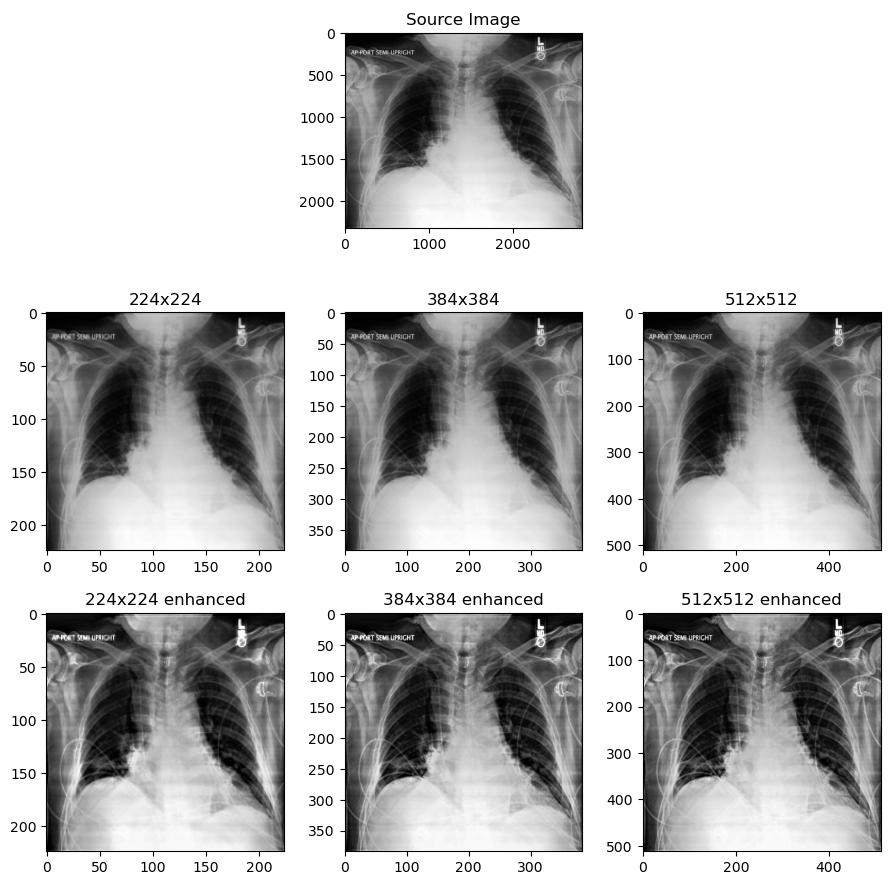

In [697]:
# --- View each iteration of the image
cols = ["source_file_path",
        "base224_file_path", "base384_file_path", "base512_file_path",
        "base224_file_path2", "base384_file_path", "base512_file_path2"]
plot_cols = [None, "source_file_path", None,
            "base224_file_path", "base384_file_path", "base512_file_path",
            "base224_file_path2", "base384_file_path2", "base512_file_path2"]
titles = [None, "Source Image", None,
            "224x224", "384x384", "512x512",
            "224x224 enhanced", "384x384 enhanced", "512x512 enhanced"]

print("Example File Transformations")
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,(ax,col_name,title) in enumerate(zip(axes.flatten(), plot_cols, titles)):
    if col_name:
        path = train_df.loc[43, col_name]
        print(f"Image Type = {col_name} --> {path}")
        with Image.open(path) as img:
            ax.imshow(img, cmap="gray")
            ax.set(title=title)
    else:
        ax.axis("off")

plt.tight_layout()
fig.savefig("images/Visualizing_all_images.jpg")

In [6]:
 # --- Viewing the distribution of dimensions
heights, widths = {}, {}
dims = {}

dfs = [train_df, valid_df, test_df]
df_types = ["train", "valid", "test"]

for df,df_type in zip(dfs, df_types):
    img_heights, img_widths, img_dims = [], [], []
    for i,file_path in enumerate(df[analysis_var]):
        with Image.open(file_path) as img:
            (img_height, img_width) = img.size
            img_heights.append(img_height)
            img_widths.append(img_width)
    img_dims.append((img_heights, img_widths))
    heights[df_type] = img_heights
    widths[df_type] = img_widths
    dims[df_type] = img_dims

train
Min width: 1020
Max width: 4240
Min height: 1401
Max height: 4248

valid
Min width: 1631
Max width: 3480
Min height: 1721
Max height: 4240

test
Min width: 1531
Max width: 3480
Min height: 1763
Max height: 4240



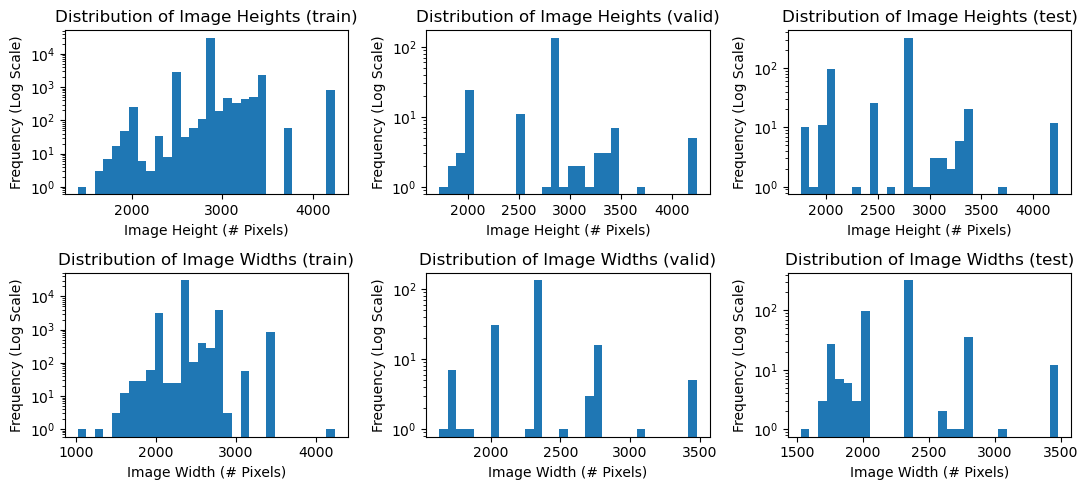

In [7]:
df_type = "test"
bins = 30
fig,ax = plt.subplots(2,3, figsize=(11,5))

for i,df_type in enumerate(df_types):
    img_heights = heights[df_type]
    img_widths = widths[df_type]
    
    min_width, max_width = min(img_widths), max(img_widths)
    min_height, max_height = min(img_heights), max(img_heights)

    print(df_type)
    print(f"Min width: {min_width}")
    print(f"Max width: {max_width}")
    print(f"Min height: {min_height}")
    print(f"Max height: {max_height}")
    print()
    
    ax[(0,i)].hist(img_heights, bins=bins, log=True)
    ax[(0,i)].set(title=f"Distribution of Image Heights ({df_type})", xlabel="Image Height (# Pixels)", ylabel="Frequency (Log Scale)")
    #
    ax[(1,i)].hist(img_widths, bins=bins, log=True)
    ax[(1,i)].set(title=f"Distribution of Image Widths ({df_type})", xlabel="Image Width (# Pixels)", ylabel="Frequency (Log Scale)")
    #

plt.tight_layout()

fig.savefig("images/img_size_histograms")

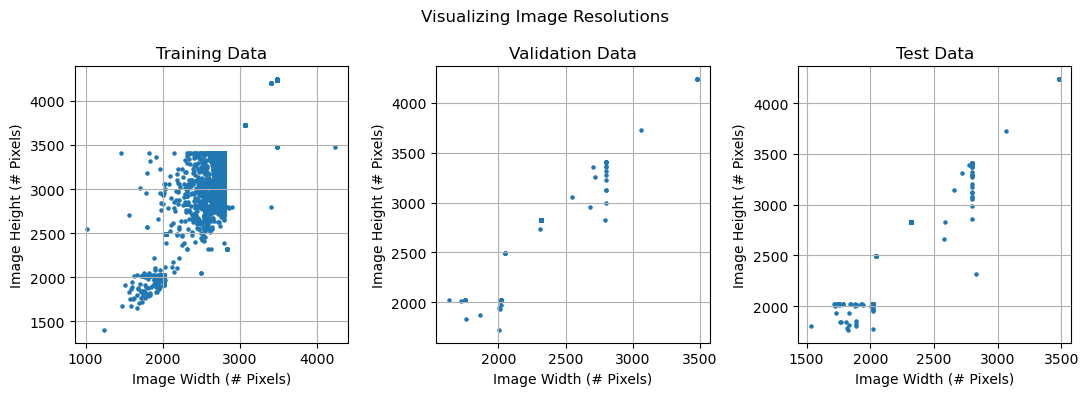

In [623]:
fig,ax = plt.subplots(1,3, figsize=(11,4))

for i,df_type in enumerate(df_types):
    df = dims[df_type]
    img_heights, img_widths = [], []
    for img_dim in dims[df_type]:
        img_heights.append(img_dim[0])
        img_widths.append(img_dim[1])

    ax[i].scatter(img_widths, img_heights, s=5)
    ax[i].set(xlabel="Image Width (# Pixels)", ylabel="Image Height (# Pixels)")
    ax[i].grid()

ax[0].set_title("Training Data")
ax[1].set_title("Validation Data")
ax[2].set_title("Test Data")
plt.suptitle("Visualizing Image Resolutions")
plt.tight_layout()

fig.savefig("images/img_size_plots")

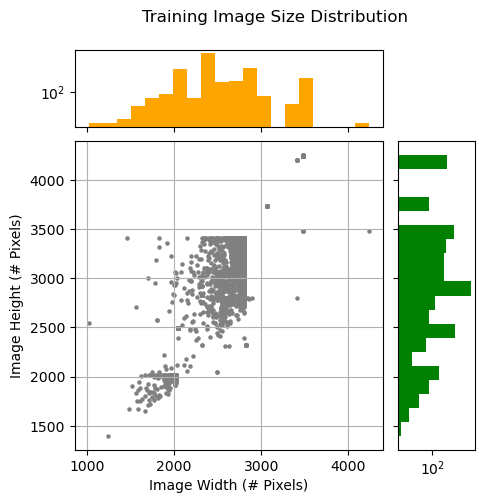

In [704]:
# Plot combined scatter plot and histogram
df_type = "train"
bins = 20

# --- Create grid
fig = plt.figure(figsize=(5,5))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.075, hspace=0.075)
plt.suptitle("Training Image Size Distribution")

# --- Create axes
ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histy = fig.add_subplot(gs[1,1], sharey=ax)

# --- Extract data
img_heights, img_widths = [], []
for img_dim in dims[df_type]:
    img_heights.append(img_dim[0])
    img_widths.append(img_dim[1])

# --- Add scatterplot
ax.scatter(img_widths, img_heights, s=5, color="gray")
ax.set(xlabel="Image Width (# Pixels)", ylabel="Image Height (# Pixels)")
ax.grid()

# --- Add histograms
ax_histx.hist(img_widths, bins=bins, color="orange", log=True)
ax_histy.hist(img_heights, bins=bins, orientation="horizontal", color="green", log=True)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

plt.show()
fig.savefig("images/img_train_scatterhist.png", bbox_inches="tight")

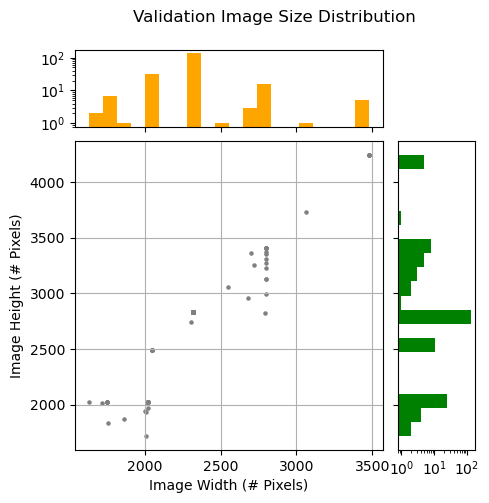

In [706]:
# Plot combined scatter plot and histogram
df_type = "valid"
bins = 20

# --- Create grid
fig = plt.figure(figsize=(5,5))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.075, hspace=0.075)
plt.suptitle("Validation Image Size Distribution")

# --- Create axes
ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histy = fig.add_subplot(gs[1,1], sharey=ax)

# --- Extract data
img_heights, img_widths = [], []
for img_dim in dims[df_type]:
    img_heights.append(img_dim[0])
    img_widths.append(img_dim[1])

# --- Add scatterplot
ax.scatter(img_widths, img_heights, s=5, color="gray")
ax.set(xlabel="Image Width (# Pixels)", ylabel="Image Height (# Pixels)")
ax.grid()

# --- Add histograms
ax_histx.hist(img_widths, bins=bins, color="orange", log=True)
ax_histy.hist(img_heights, bins=bins, orientation="horizontal", color="green", log=True)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

plt.show()
fig.savefig("images/img_valid_scatterhist", bbox_inches="tight")

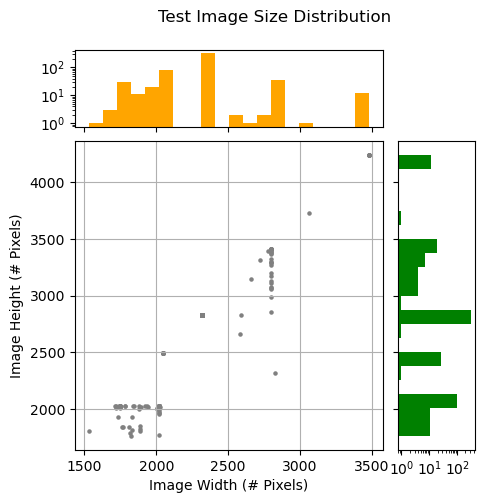

In [707]:
# Plot combined scatter plot and histogram
df_type = "test"
bins = 20

# --- Create grid
fig = plt.figure(figsize=(5,5))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.075, hspace=0.075)
plt.suptitle("Test Image Size Distribution")

# --- Create axes
ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histy = fig.add_subplot(gs[1,1], sharey=ax)

# --- Extract data
img_heights, img_widths = [], []
for img_dim in dims[df_type]:
    img_heights.append(img_dim[0])
    img_widths.append(img_dim[1])

# --- Add scatterplot
ax.scatter(img_widths, img_heights, s=5, color="gray")
ax.set(xlabel="Image Width (# Pixels)", ylabel="Image Height (# Pixels)")
ax.grid()

# --- Add histograms
ax_histx.hist(img_widths, bins=bins, color="orange", log=True)
ax_histy.hist(img_heights, bins=bins, orientation="horizontal", color="green", log=True)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

plt.show()
fig.savefig("images/img_test_scatterhist", bbox_inches="tight")

In [510]:
# train_stats = train_df.copy()

In [511]:
# %%time
# # Compile image information on the training data frame
# #
# img_heights0, img_widths0 = [], []
# max_value0, min_value0, value_range0 = [], [], []
# img_mean0, img_var0 = [], []
# #
# img_heights1, img_widths1 = [], []
# max_value1, min_value1, value_range1 = [], [], []
# img_mean1, img_var1 = [], []
# #
# img_heights2, img_widths2 = [], []
# max_value2, min_value2, value_range2 = [], [], []
# img_mean2, img_var2 = [], []
# #
# img_heights3, img_widths3 = [], []
# max_value3, min_value3, value_range3 = [], [], []
# img_mean3, img_var3 = [], []
# # --- Record any file paths that caused error for review
# error_file_paths = []
# #
# for i,(source_img_path,base224_file_path,base384_file_path,base512_file_path) in enumerate(zip(train_stats["source_file_path"], 
#                                                                                               train_stats[f"base224_file_path"],
#                                                                                               train_stats[f"base384_file_path"],
#                                                                                               train_stats[f"base512_file_path"],), start=1):
#     with Image.open(source_img_path) as img:
#         img_arr = np.array(img)
#         if scale_min == scale_max:
#             error_file_paths.append(source_img_path)
#         else:
#             img_arr = scale_range(img_arr, scale_min, scale_max)
#             (img_height, img_width) = img.size
#             img_heights0.append(img_height)
#             img_widths0.append(img_width)
#             img_max, img_min = img_arr.max(), img_arr.min()
#             max_value0.append(img_max)
#             min_value0.append(img_min)
#             value_range0 = img_max - img_min
#             img_mean0.append(img_arr.mean())
#             img_var0.append(img_arr.var())
#     with Image.open(base224_file_path) as img:
#         img_arr = np.array(img)
#         if scale_min == scale_max:
#             error_file_paths.append(source_img_path)
#         else:
#             img_arr = scale_range(img_arr, scale_min, scale_max)
#             (img_height, img_width) = img.size
#             img_heights1.append(img_height)
#             img_widths1.append(img_width)
#             img_max, img_min = img_arr.max(), img_arr.min()
#             max_value1.append(img_max)
#             min_value1.append(img_min)
#             value_range1 = img_max - img_min
#             img_mean1.append(img_arr.mean())
#             img_var1.append(img_arr.var())
#     with Image.open(base384_file_path) as img:
#         img_arr = np.array(img)
#         if scale_min == scale_max:
#             error_file_paths.append(source_img_path)
#         else:
#             img_arr = scale_range(img_arr, scale_min, scale_max)
#             (img_height, img_width) = img.size
#             img_heights2.append(img_height)
#             img_widths2.append(img_width)
#             img_max, img_min = img_arr.max(), img_arr.min()
#             max_value2.append(img_max)
#             min_value2.append(img_min)
#             value_range2 = img_max - img_min
#             img_mean2.append(img_arr.mean())
#             img_var2.append(img_arr.var())
#     with Image.open(base512_file_path) as img:
#         img_arr = np.array(img)
#         if scale_min == scale_max:
#             error_file_paths.append(source_img_path)
#         else:
#             img_arr = scale_range(img_arr, scale_min, scale_max)
#             (img_height, img_width) = img.size
#             img_heights3.append(img_height)
#             img_widths3.append(img_width)
#             img_max, img_min = img_arr.max(), img_arr.min()
#             max_value3.append(img_max)
#             min_value3.append(img_min)
#             value_range3 = img_max - img_min
#             img_mean3.append(img_arr.mean())
#             img_var3.append(img_arr.var())
            
# train_stats["source_img_height"] = img_heights0
# train_stats["source_img_width"] = img_widths0
# train_stats["source_img_max"] = max_value0
# train_stats["source_img_min"] = min_value0
# train_stats["source_img_range"] = value_range0
# train_stats["source_img_mean"] = img_mean0
# train_stats["source_img_var"] = img_var0
# #
# train_stats["base224_img_height"] = img_heights1
# train_stats["base224_img_width"] = img_widths1
# train_stats["base224_img_max"] = max_value1
# train_stats["base224_img_min"] = min_value1
# train_stats["base224_img_range"] = value_range1
# train_stats["base224_img_mean"] = img_mean1
# train_stats["base224_img_var"] = img_var1
# #
# train_stats["base384_img_height"] = img_heights2
# train_stats["base384_img_width"] = img_widths2
# train_stats["base384_img_max"] = max_value2
# train_stats["base384_img_min"] = min_value2
# train_stats["base384_img_range"] = value_range2
# train_stats["base384_img_mean"] = img_mean2
# train_stats["base384_img_var"] = img_var2
# #
# train_stats["base512_img_height"] = img_heights3
# train_stats["base512_img_width"] = img_widths3
# train_stats["base512_img_max"] = max_value3
# train_stats["base512_img_min"] = min_value3
# train_stats["base512_img_range"] = value_range3
# train_stats["base512_img_mean"] = img_mean3
# train_stats["base512_img_var"] = img_var3

In [512]:
# print(error_file_paths)

In [513]:
cols = ["source_file_path", "base224_file_path", "base384_file_path", "base512_file_path",
        "source_img_height","source_img_width","source_img_max",
        "source_img_min","source_img_range","source_img_mean",
        "source_img_var",
        "base224_img_height","base224_img_width","base224_img_max",
        "base224_img_min","base224_img_range","base224_img_mean",
        "base224_img_var",
        "base384_img_height","base384_img_width","base384_img_max",
        "base384_img_min","base384_img_range","base384_img_mean",
        "base384_img_var",
        "base512_img_height","base512_img_width","base512_img_max",
        "base512_img_min","base512_img_range","base512_img_mean",
        "base512_img_var",
       ]

In [642]:
train_stats.to_csv(f"{root}train_stats.csv", index=False)

train_stats = pd.read_csv(f"{root}train_stats.csv")

In [508]:
# View the average training x-ray
dim0 = 512

avg_img_arr = np.zeros((dim0, dim0))
avg_img_arr_sqrd = np.zeros((dim0, dim0))

### Online mean computations
for i,img_path in enumerate(train_df[f"base{dim0}_file_path"], start=1):
    with Image.open(img_path) as img:
        img_arr = np.array(img)
        img_arr = scale_range(img_arr, scale_min, scale_max)
        avg_img_arr = (1 - (1 / i)) * avg_img_arr + (1 / i) * img_arr
        avg_img_arr_sqrd = (1 - (1/i)) * avg_img_arr_sqrd + (1/i)*(img_arr**2)

var_img_arr = avg_img_arr_sqrd - (avg_img_arr)**2
std_img_arr = np.sqrt(var_img_arr)

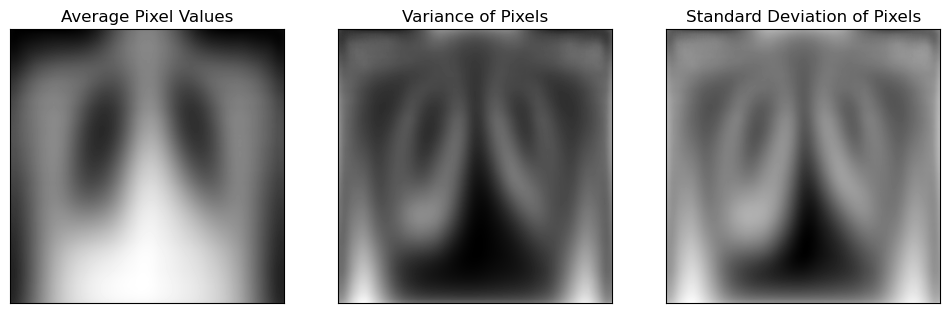

In [703]:
### Show avg/var/std
fig, ax = plt.subplots(1,3, figsize=(12,5))
fig.suptitle=(" ")

ax[0].imshow(avg_img_arr, cmap="gray")
ax[1].imshow(var_img_arr, cmap="gray")
ax[2].imshow(std_img_arr, cmap="gray")

ax[0].set(title="Average Pixel Values", xticks=[], yticks=[])
ax[1].set(title="Variance of Pixels", xticks=[], yticks=[])
ax[2].set(title="Standard Deviation of Pixels", xticks=[], yticks=[])

# plt.tight_layout()
fig.savefig("images/avg_var_std_pixels.png", bbox_inches="tight")

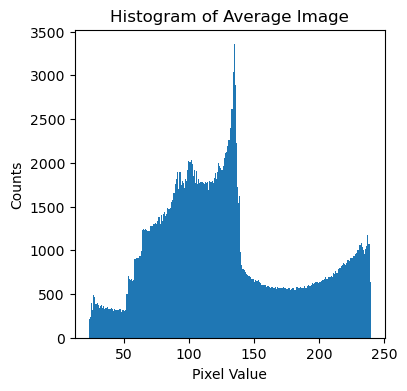

In [609]:
### View the histogram of the average image
fig,ax = plt.subplots(1,1,figsize=(4,4))

###
ax.hist(avg_img_arr.flatten(), bins=255)
ax.set(title="Histogram of Average Image", xlabel="Pixel Value", ylabel="Counts")
fig.savefig("images/avg_img_histogram.png")

In [23]:
train_stats[cols].describe()

source_img_height  source_img_width  source_img_max  source_img_min  \
count       39371.000000      39371.000000         39371.0         39371.0   
mean         2878.064286       2373.157883           255.0             0.0   
std           286.444039        238.014930             0.0             0.0   
min          1401.000000       1020.000000           255.0             0.0   
25%          2828.000000       2320.000000           255.0             0.0   
50%          2828.000000       2320.000000           255.0             0.0   
75%          2828.000000       2320.000000           255.0             0.0   
max          4248.000000       4240.000000           255.0             0.0   

       source_img_range  source_img_mean  source_img_var  base224_img_height  \
count           39371.0     39371.000000    39371.000000             39371.0   
mean              255.0       129.142495     5455.960744               224.0   
std                 0.0         1.470958      112.934968                 0.0   
min               255.0        83.832787       52.494197               224.0   
25%               255.0       128.940374     5429.264132               224.0   
50%               255.0       129.213211     5456.216679               224.0   
75%               255.0       129.490176     5486.460904               224.0   
max               255.0       254.790959     7627.955907               224.0   

       base224_img_width  base224_img_max  ...  base384_img_range  \
count            39371.0          39371.0  ...            39371.0   
mean               224.0            255.0  ...              255.0   
std                  0.0              0.0  ...                0.0   
min                224.0            255.0  ...              255.0   
25%                224.0            255.0  ...              255.0   
50%                224.0            255.0  ...              255.0   
75%                224.0            255.0  ...              255.0   
max                224.0            255.0  ...              255.0   

       base384_img_mean  base384_img_var  base512_img_height  \
count      39371.000000     39371.000000             39371.0   
mean         128.717776      5362.642378               512.0   
std            1.475789       112.023729                 0.0   
min           83.532172        26.891792               512.0   
25%          128.494649      5334.864301               512.0   
50%          128.780219      5363.988191               512.0   
75%          129.087684      5393.106281               512.0   
max          254.741191      7496.193152               512.0   

       base512_img_width  base512_img_max  base512_img_min  base512_img_range  \
count            39371.0          39371.0          39371.0            39371.0   
mean               512.0            255.0              0.0              255.0   
std                  0.0              0.0              0.0                0.0   
min                512.0            255.0              0.0              255.0   
25%                512.0            255.0              0.0              255.0   
50%                512.0            255.0              0.0              255.0   
75%                512.0            255.0              0.0              255.0   
max                512.0            255.0              0.0              255.0   

       base512_img_mean  base512_img_var  
count      39371.000000     39371.000000  
mean         128.678820      5374.511602  
std            1.471141       111.402024  
min           83.531502        31.029891  
25%          128.471487      5349.039303  
50%          128.745197      5376.194496  
75%          129.035036      5403.258508  
max          254.756390      7521.790878  

[8 rows x 28 columns]

In [57]:
# Compare means
cols = ["source_img_height","source_img_width","source_img_max",
        "source_img_min","source_img_range","source_img_mean",
        "source_img_var",
        "base224_img_height","base224_img_width","base224_img_max",
        "base224_img_min","base224_img_range","base224_img_mean",
        "base224_img_var",
        "base384_img_height","base384_img_width","base384_img_max",
        "base384_img_min","base384_img_range","base384_img_mean",
        "base384_img_var",
        "base512_img_height","base512_img_width","base512_img_max",
        "base512_img_min","base512_img_range","base512_img_mean",
        "base512_img_var",
        "source_file_path", "base224_file_path", "base384_file_path", "base512_file_path"
       ]
source_cols = ["source_img_height","source_img_width","source_img_max",
               "source_img_min","source_img_range","source_img_mean",
               "source_img_var",
               "source_file_path", "base224_file_path", "base384_file_path", "base512_file_path"]
base224_cols = ["base224_img_height","base224_img_width","base224_img_max",
                "base224_img_min","base224_img_range","base224_img_mean",
                "base224_img_var",
                "source_file_path", "base224_file_path", "base384_file_path", "base512_file_path",]
base384_cols = ["base384_img_height","base384_img_width","base384_img_max",
                "base384_img_min","base384_img_range","base384_img_mean",
                "base384_img_var",
                "source_file_path", "base224_file_path", "base384_file_path", "base512_file_path"]
base512_cols = ["base512_img_height","base512_img_width","base512_img_max",
                "base512_img_min","base512_img_range","base512_img_mean",
                "base512_img_var",
                "source_file_path", "base224_file_path", "base384_file_path", "base512_file_path"]


In [27]:
train_stats[source_cols].describe()

source_img_height  source_img_width  source_img_max  source_img_min  \
count       39371.000000      39371.000000         39371.0         39371.0   
mean         2878.064286       2373.157883           255.0             0.0   
std           286.444039        238.014930             0.0             0.0   
min          1401.000000       1020.000000           255.0             0.0   
25%          2828.000000       2320.000000           255.0             0.0   
50%          2828.000000       2320.000000           255.0             0.0   
75%          2828.000000       2320.000000           255.0             0.0   
max          4248.000000       4240.000000           255.0             0.0   

       source_img_range  source_img_mean  source_img_var  
count           39371.0     39371.000000    39371.000000  
mean              255.0       129.142495     5455.960744  
std                 0.0         1.470958      112.934968  
min               255.0        83.832787       52.494197  
25%               255.0       128.940374     5429.264132  
50%               255.0       129.213211     5456.216679  
75%               255.0       129.490176     5486.460904  
max               255.0       254.790959     7627.955907

In [28]:
train_stats[base224_cols].describe()

base224_img_height  base224_img_width  base224_img_max  \
count             39371.0            39371.0          39371.0   
mean                224.0              224.0            255.0   
std                   0.0                0.0              0.0   
min                 224.0              224.0            255.0   
25%                 224.0              224.0            255.0   
50%                 224.0              224.0            255.0   
75%                 224.0              224.0            255.0   
max                 224.0              224.0            255.0   

       base224_img_min  base224_img_range  base224_img_mean  base224_img_var  
count          39371.0            39371.0      39371.000000     39371.000000  
mean               0.0              255.0        128.793701      5336.079134  
std                0.0                0.0          1.479512       114.097098  
min                0.0              255.0         83.549466        19.407068  
25%                0.0              255.0        128.540846      5300.864664  
50%                0.0              255.0        128.848573      5335.978241  
75%                0.0              255.0        129.183554      5371.109309  
max                0.0              255.0        254.699797      7424.478500

In [29]:
train_stats[base384_cols].describe()

base384_img_height  base384_img_width  base384_img_max  \
count             39371.0            39371.0          39371.0   
mean                384.0              384.0            255.0   
std                   0.0                0.0              0.0   
min                 384.0              384.0            255.0   
25%                 384.0              384.0            255.0   
50%                 384.0              384.0            255.0   
75%                 384.0              384.0            255.0   
max                 384.0              384.0            255.0   

       base384_img_min  base384_img_range  base384_img_mean  base384_img_var  
count          39371.0            39371.0      39371.000000     39371.000000  
mean               0.0              255.0        128.717776      5362.642378  
std                0.0                0.0          1.475789       112.023729  
min                0.0              255.0         83.532172        26.891792  
25%                0.0              255.0        128.494649      5334.864301  
50%                0.0              255.0        128.780219      5363.988191  
75%                0.0              255.0        129.087684      5393.106281  
max                0.0              255.0        254.741191      7496.193152

In [30]:
train_stats[base512_cols].describe()

base512_img_height  base512_img_width  base512_img_max  \
count             39371.0            39371.0          39371.0   
mean                512.0              512.0            255.0   
std                   0.0                0.0              0.0   
min                 512.0              512.0            255.0   
25%                 512.0              512.0            255.0   
50%                 512.0              512.0            255.0   
75%                 512.0              512.0            255.0   
max                 512.0              512.0            255.0   

       base512_img_min  base512_img_range  base512_img_mean  base512_img_var  
count          39371.0            39371.0      39371.000000     39371.000000  
mean               0.0              255.0        128.678820      5374.511602  
std                0.0                0.0          1.471141       111.402024  
min                0.0              255.0         83.531502        31.029891  
25%                0.0              255.0        128.471487      5349.039303  
50%                0.0              255.0        128.745197      5376.194496  
75%                0.0              255.0        129.035036      5403.258508  
max                0.0              255.0        254.756390      7521.790878

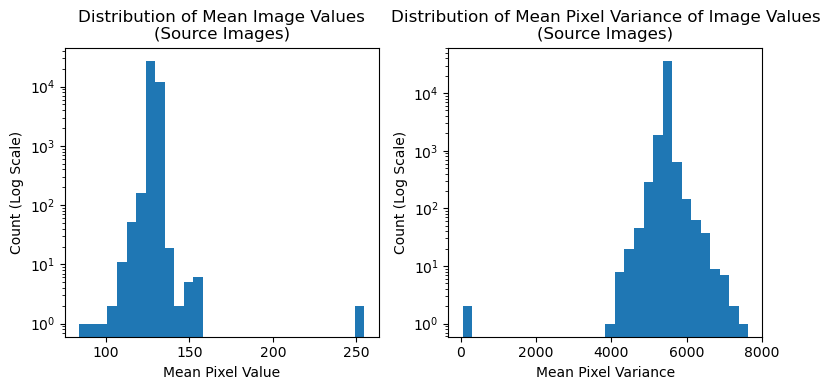

In [49]:
# Distribution of means
data = train_stats["source_img_mean"]

fig,ax = plt.subplots(1,2, figsize=(8,4))
ax[0].hist(data, bins=30, log=True)
ax[0].set(title="Distribution of Mean Image Values\n(Source Images)",
          xlabel="Mean Pixel Value",
          ylabel="Count (Log Scale)"
         )
ax[1].hist(train_stats["source_img_var"], bins=30, log=True)
ax[1].set(title="Distribution of Mean Pixel Variance of Image Values\n(Source Images)",
          xlabel="Mean Pixel Variance",
          ylabel="Count (Log Scale)"
         )

plt.tight_layout()
plt.show()

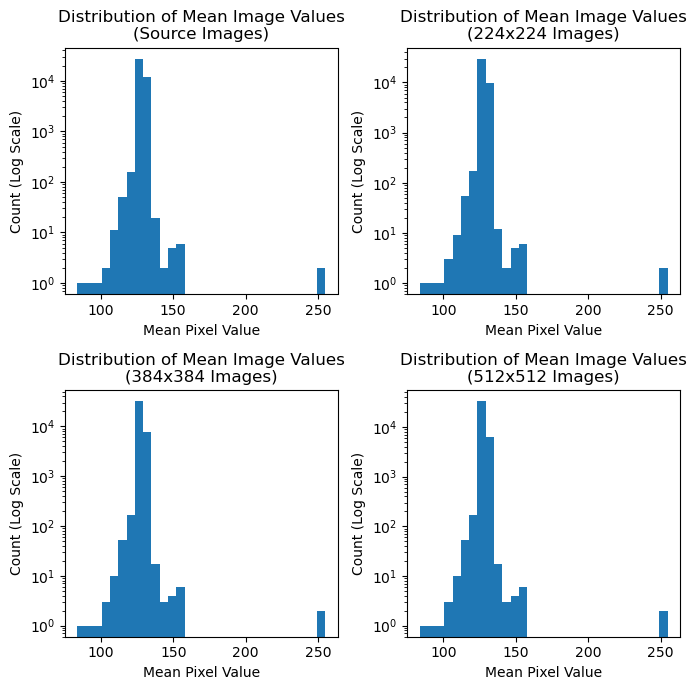

In [45]:
# Distribution of means
fig,axes = plt.subplots(2,2, figsize=(7,7))
ax = axes.flatten()

ax[0].hist(train_stats["source_img_mean"], bins=30, log=True)
ax[0].set(title="Distribution of Mean Image Values\n(Source Images)",
          xlabel="Mean Pixel Value",
          ylabel="Count (Log Scale)"
         )
ax[1].hist(train_stats["base224_img_mean"], bins=30, log=True)
ax[1].set(title="Distribution of Mean Image Values\n(224x224 Images)",
          xlabel="Mean Pixel Value",
          ylabel="Count (Log Scale)"
         )
ax[2].hist(train_stats["base384_img_mean"], bins=30, log=True)
ax[2].set(title="Distribution of Mean Image Values\n(384x384 Images)",
          xlabel="Mean Pixel Value",
          ylabel="Count (Log Scale)"
         )
ax[3].hist(train_stats["base512_img_mean"], bins=30, log=True)
ax[3].set(title="Distribution of Mean Image Values\n(512x512 Images)",
          xlabel="Mean Pixel Value",
          ylabel="Count (Log Scale)"
         )

plt.tight_layout()
plt.show()

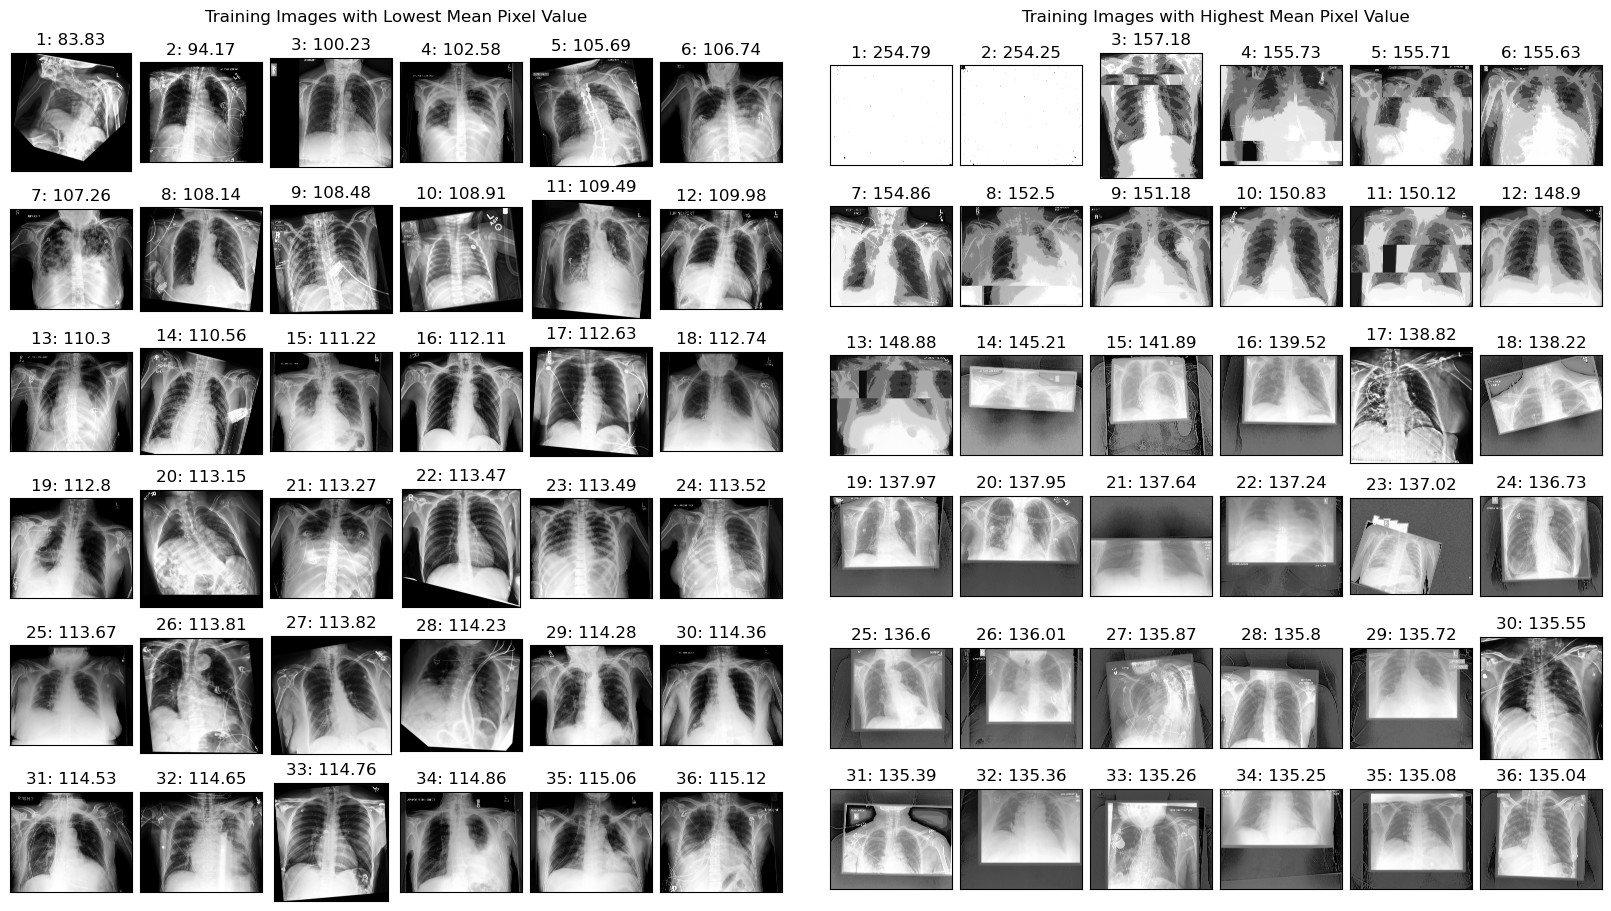

In [110]:
# Viewing the images with the lowest variances
var = "source_img_mean"
df = train_stats.sort_values(by=var, ascending=True)[source_cols]

# --- Prepare subfigures
fig = plt.figure(constrained_layout=True, figsize=(16,9))
subfigs = fig.subfigures(1,2, wspace=0.05)
subfigs[0].suptitle("Training Images with Lowest Mean Pixel Value")
subfigs[1].suptitle("Training Images with Highest Mean Pixel Value")

axes0 = subfigs[0].subplots(6,6)
axes1 = subfigs[1].subplots(6,6)

# --- Get data and display it
df0 = df.head(36)[source_cols]
for i,(ax,img_var,path) in enumerate(zip(axes0.flatten(), df0[var], df0["source_file_path"]), start=1):
    with Image.open(path) as img:
        ax.imshow(img, cmap="gray")
        ax.set(title=f"{i}: {round(img_var,2)}",xticks=[], yticks=[])
df1 = df.tail(36)[source_cols][::-1]
for i,(ax,img_var,path) in enumerate(zip(axes1.flatten(), df1[var], df1["source_file_path"]), start=1):
    with Image.open(path) as img:
        ax.imshow(img, cmap="gray")
        ax.set(title=f"{i}: {round(img_var,2)}",xticks=[], yticks=[])

# fig.savefig("images/img_viewMeans.jpg")

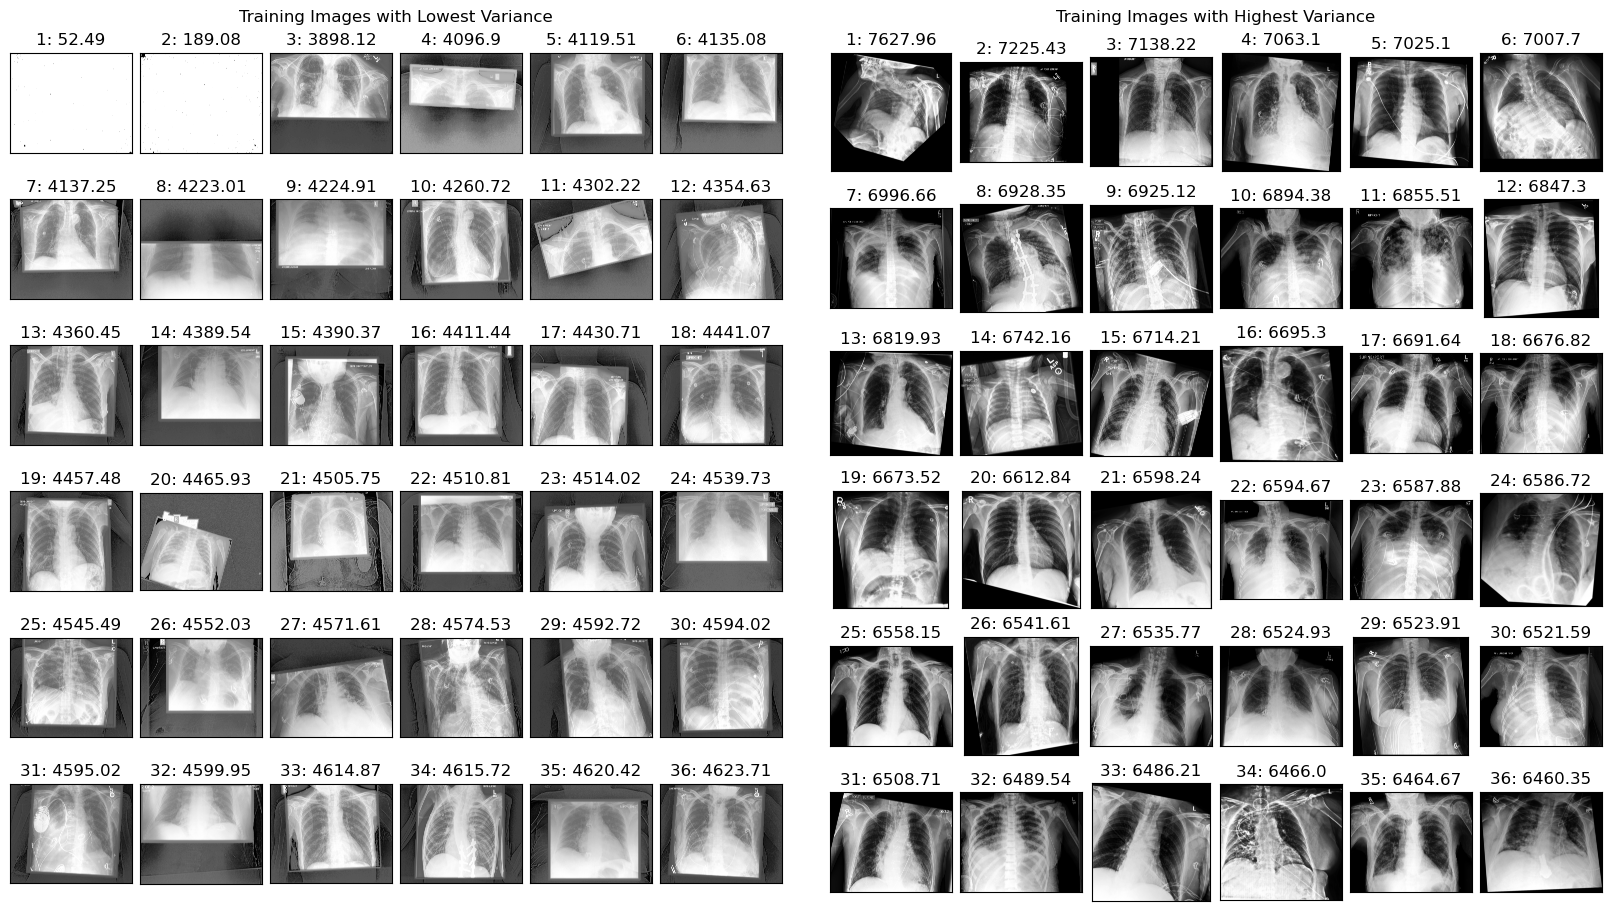

In [615]:
# Viewing the images with the lowest variances
var = "source_img_var"
df = train_stats.sort_values(by=var, ascending=True)[source_cols]

# --- Prepare subfigures
fig = plt.figure(constrained_layout=True, figsize=(16,9))
subfigs = fig.subfigures(1,2, wspace=0.05)
subfigs[0].suptitle("Training Images with Lowest Variance")
subfigs[1].suptitle("Training Images with Highest Variance")

axes0 = subfigs[0].subplots(6,6)
axes1 = subfigs[1].subplots(6,6)

# --- Get data and display it
df0 = df.head(36)[source_cols]
for i,(ax,img_var,path) in enumerate(zip(axes0.flatten(), df0[var], df0["source_file_path"]), start=1):
    with Image.open(path) as img:
        ax.imshow(img, cmap="gray")
        ax.set(title=f"{i}: {round(img_var,2)}",xticks=[], yticks=[])
df1 = df.tail(36)[source_cols][::-1]
for i,(ax,img_var,path) in enumerate(zip(axes1.flatten(), df1[var], df1["source_file_path"]), start=1):
    with Image.open(path) as img:
        ax.imshow(img, cmap="gray")
        ax.set(title=f"{i}: {round(img_var,2)}",xticks=[], yticks=[])

# fig.savefig("images/img_viewVariances.jpg")

f"{source_train_root}patient48043/study1/view2_frontal.jpg",
f"{source_train_root}patient44163/study1/view1_frontal.jpg",
f"{source_train_root}patient60655/study1/view1_frontal.jpg",
f"{source_train_root}patient52670/study1/view1_frontal.jpg",
f"{source_train_root}patient56384/study1/view1_frontal.jpg",
f"{source_train_root}patient52150/study1/view1_frontal.jpg",
f"{source_train_root}patient46703/study2/view1_frontal.jpg",
f"{source_train_root}patient56024/study1/view1_frontal.jpg",
f"{source_train_root}patient49936/study1/view1_frontal.jpg",
f"{source_train_root}patient50284/study3/view1_frontal.jpg",
f"{source_train_root}patient55832/study2/view1_frontal.jpg",
f"{source_train_root}patient62069/study1/view1_frontal.jpg",
f"{source_train_root}patient43440/study3/view1_frontal.jpg",


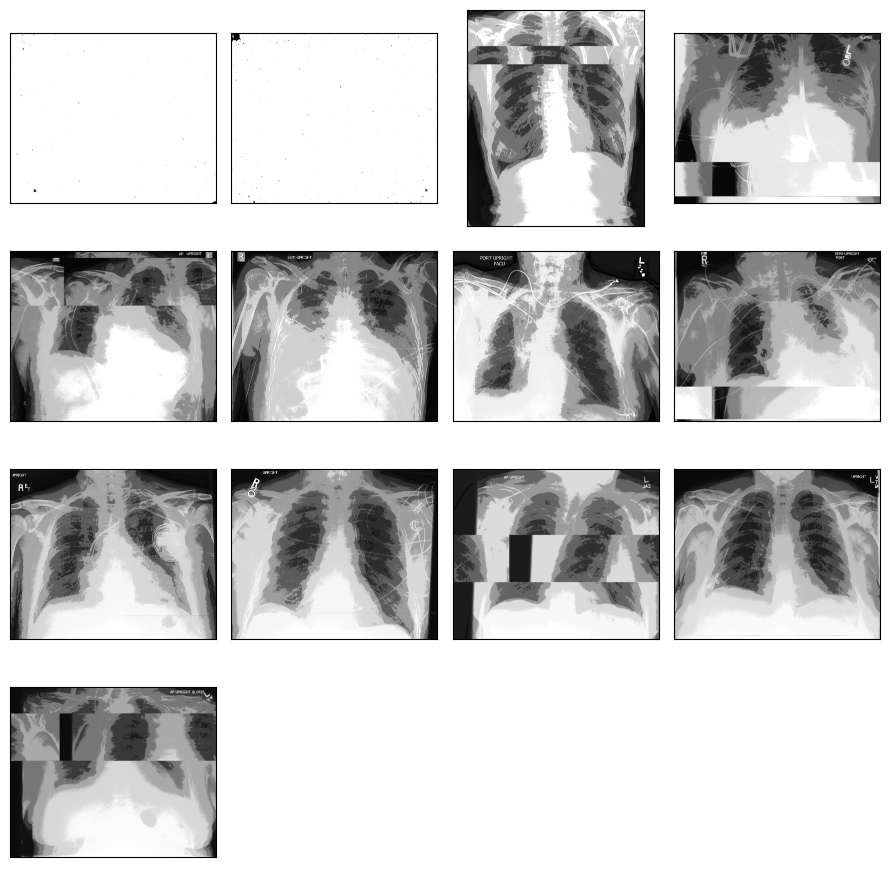

In [613]:
# Viewing the first 13 images in train_stats with the highest mean value
filter_out_paths = list(train_stats.sort_values(by="source_img_mean", ascending=False).head(13)["source_file_path"])

for path in list(train_stats.sort_values(by="source_img_mean", ascending=False).head(13)["floating_file_path"]):
    print("f\"{source_train_root}" + path + "\",")

#
fig,axes = plt.subplots(4,4, figsize=(9,9))

# --- Uncomment this to view only the first 13 images
for i,ax in enumerate(axes.flatten()):
    if i > 12: 
        ax.axis("off")
    else:
        with Image.open(filter_out_paths[i]) as img:
            ax.imshow(img, cmap="gray")
            ax.set(xticks=[], yticks=[])

# # --- Uncomment this to view all images
# for i,ax in enumerate(axes.flatten()):
#     with Image.open(filter_out_paths[i]) as img:
#         ax.imshow(img, cmap="gray")
#         ax.set(xticks=[], yticks=[])

plt.tight_layout()
# fig.savefig("images/error_images.jpg")

In [560]:
n = 27865
bins = 255
path_type = "base512_file_path"

In [581]:
def get_psnr(img_arr, img_arr2, scale_max):
    """ Calculates the peak signal-to-noise ratio in dB between an edited image (img_arr2) and the original (img_arr)"""
    img_arr = img_arr.astype(np.float64)
    img_arr2 = img_arr2.astype(np.float64)
    mse = np.mean((img_arr - img_arr2)**2)
    if mse==0: 
        return np.inf
    else:
        return 20 * math.log10(scale_max) - 10 * math.log10(mse)

In [602]:
def unsharp_masking(img_arr, sigma, weight):
    """Enhance the image by increasing edge contrasts"""
    blurred = gaussian_filter(img_arr, sigma)
    return img_arr + (img_arr - blurred) * weight

In [631]:
# Testing sharpening and contrast increases

# --- Get image
with Image.open(train_df.loc[n, path_type]) as img:
    img_arr = np.array(img)
img_arr = scale_range(img_arr, scale_min, scale_max)
img_arr_he = histogram_equalization(img_arr, scale_min, scale_max, he_sigma)    

# --- Histogram equalization
he_sigma = 5

# --- Sharpening with convolve filter + histogram equalization
center = 9
edge = -1
corner = -1

sharpen_kernel = np.array([[corner, edge, corner],
                           [edge,   center, edge],
                           [corner, edge, corner]])

conv = convolve(img_arr, sharpen_kernel)
conv = scale_range(conv, scale_min, scale_max)
conv_he = histogram_equalization(conv, scale_min, scale_max, he_sigma)
#
conv_psnr = get_psnr(img_arr, conv, scale_max)
conv_he_psnr = get_psnr(img_arr, conv_he, scale_max)
conv_ssim = structural_similarity(img_arr, conv, data_range=(scale_max-scale_min))
conv_he_ssim = structural_similarity(img_arr, conv_he, data_range=(scale_max-scale_min))

# --- Unsharp Masking + histogram equalization
usm_sigma = 10
weight = 1.2

usm = unsharp_masking(img_arr, usm_sigma, weight)
usm = scale_range(usm, scale_min, scale_max)
usm_he = histogram_equalization(usm, scale_min, scale_max, he_sigma)
#
usm_psnr = get_psnr(img_arr, usm, scale_max)
usm_he_psnr = get_psnr(img_arr, usm_he, scale_max)
usm_ssim = structural_similarity(img_arr, usm, data_range=(scale_max-scale_min))
usm_he_ssim = structural_similarity(img_arr, usm_he, data_range=(scale_max-scale_min))

# --- XDoG + histogram equalization
xdog_k = 50    ### k scales Gaussians - this increases contrast
xdog_sigma = 0.5     ### sigma determines the initial blur strength - higher values discard finer details
xdog_tau = 10     ### tau scales the values of the second blurred image - higher values increase sharpness
xdog_ep = 0.7 * (scale_max - scale_min)     ### ep is the cutoff that determines what values become hard edges
xdog_phi = 0.01      ### phi is a parameter in tanh that affects how much the darker areas can be seen - smaller values retain more detail
xdog_threshold = "tanh"     ### threshold type: None, binary, tanh
xdog_truncate = 1      ### truncate: This determines the kernel of the Gaussian filter which affects smoothing

xdog1 = xdog(img_arr, 
            xdog_k, 
            xdog_sigma, 
            xdog_tau, 
            xdog_ep, 
            xdog_phi, 
            scale_min, scale_max, 
            xdog_truncate, 
            xdog_threshold)
xdog1 = scale_range(xdog1, scale_min, scale_max)
xdog1_he = histogram_equalization(xdog1, scale_min, scale_max, he_sigma)
#
xdog1_psnr = get_psnr(img_arr, xdog1, scale_max)
xdog1_he_psnr = get_psnr(img_arr, xdog1_he, scale_max)
xdog1_ssim = structural_similarity(img_arr, xdog1, data_range=(scale_max-scale_min))
xdog1_he_ssim = structural_similarity(img_arr, xdog1_he, data_range=(scale_max-scale_min))

# --- XDoG2 (Edges) + histogram equalization
xdog_k = 1.6     ### k scales Gaussians - this increases contrast
xdog_sigma = 1.5     ### sigma determines the initial blur strength - higher values discard finer details
xdog_tau = 100    ### tau scales the values of the second blurred image - higher values increase sharpness
xdog_ep = None     ### ep is the cutoff that determines what values become hard edges
xdog_phi = None      ### phi is a parameter in tanh that affects how much the darker areas can be seen - smaller values retain more detail
xdog_threshold = None     ### threshold type: None, binary, tanh
xdog_truncate = 2      ### truncate: This determines the kernel of the Gaussian filter which affects smoothing

xdog2 = xdog(img_arr, 
            xdog_k, 
            xdog_sigma, 
            xdog_tau, 
            xdog_ep, 
            xdog_phi, 
            scale_min, scale_max, 
            xdog_truncate, 
            xdog_threshold)
xdog2 = scale_range(xdog2, scale_min, scale_max)
xdog2_he = histogram_equalization(xdog2, scale_min, scale_max, he_sigma)
#
xdog2_psnr = get_psnr(img_arr, xdog2, scale_max)
xdog2_he_psnr = get_psnr(img_arr, xdog2_he, scale_max)
xdog2_ssim = structural_similarity(img_arr, xdog2, data_range=(scale_max-scale_min))
xdog2_he_ssim = structural_similarity(img_arr, xdog2_he, data_range=(scale_max-scale_min))

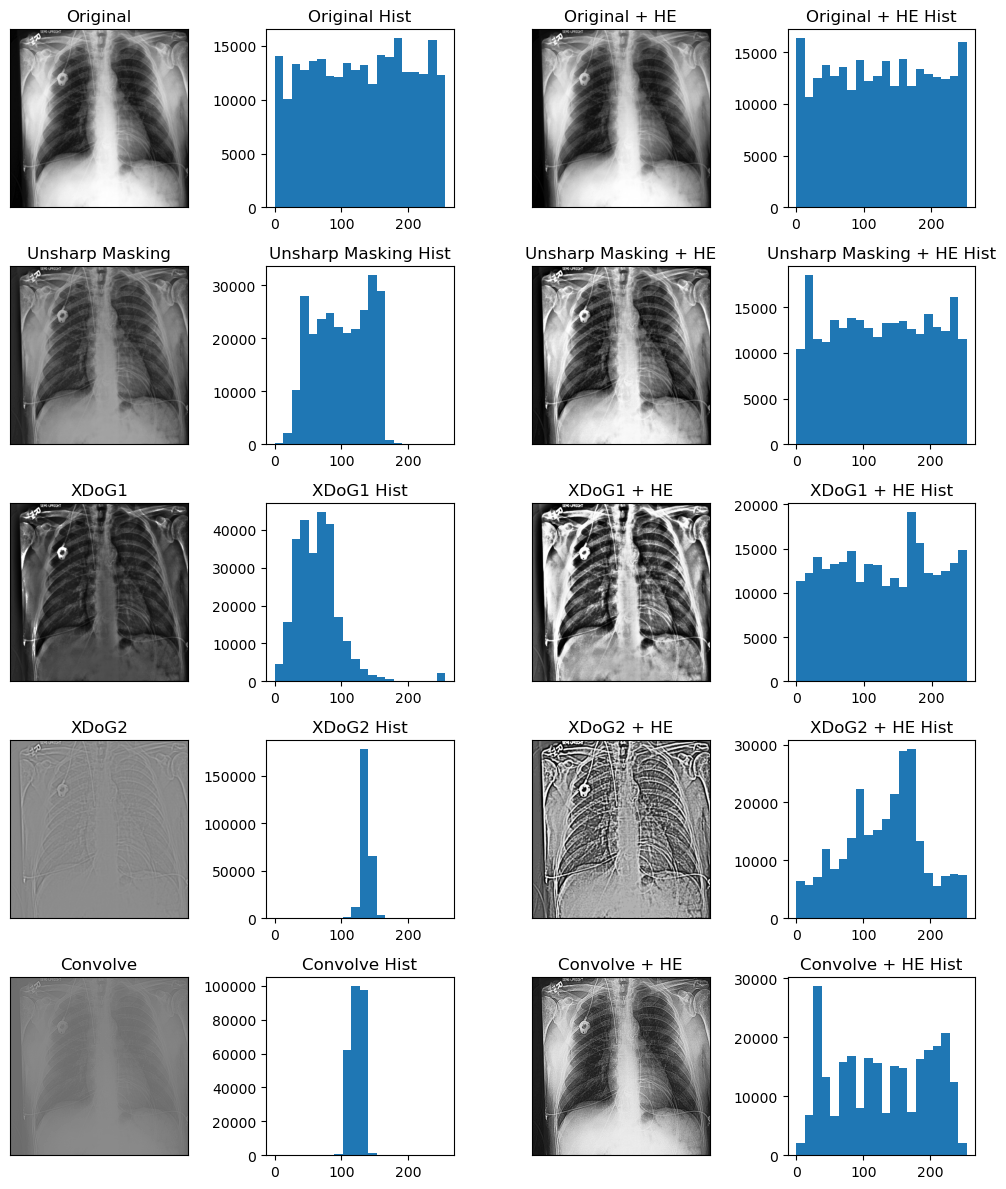

In [632]:



fig,axes = plt.subplots(5,4,figsize=(10,12))
ax = axes.flatten()

###
ax[0].imshow(img_arr, cmap="gray")
ax[0].set(title="Original", xticks=[], yticks=[])
#
ax[1].hist(img_arr.flatten(), bins=bins)
ax[1].set(title="Original Hist")
#
ax[2].imshow(img_arr_he, cmap="gray")
ax[2].set(title="Original + HE", xticks=[], yticks=[])
#
ax[3].hist(img_arr_he.flatten(), bins=bins)
ax[3].set(title="Original + HE Hist")
#####
ax[4].imshow(usm, cmap="gray")
ax[4].set(title="Unsharp Masking", xticks=[], yticks=[])
#
ax[5].hist(usm.flatten(), bins=bins)
ax[5].set(title="Unsharp Masking Hist")
#
ax[6].imshow(usm_he, cmap="gray")
ax[6].set(title="Unsharp Masking + HE", xticks=[], yticks=[])
#
ax[7].hist(usm_he.flatten(), bins=bins)
ax[7].set(title="Unsharp Masking + HE Hist")
#####
ax[8].imshow(xdog1, cmap="gray")
ax[8].set(title="XDoG1", xticks=[], yticks=[])
#
ax[9].hist(xdog1.flatten(), bins=bins)
ax[9].set(title="XDoG1 Hist")
#
ax[10].imshow(xdog1_he, cmap="gray")
ax[10].set(title="XDoG1 + HE", xticks=[], yticks=[])
#
ax[11].hist(xdog1_he.flatten(), bins=bins)
ax[11].set(title="XDoG1 + HE Hist")
#####
ax[12].imshow(xdog2, cmap="gray")
ax[12].set(title="XDoG2", xticks=[], yticks=[])
#
ax[13].hist(xdog2.flatten(), bins=bins)
ax[13].set(title="XDoG2 Hist")
#
ax[14].imshow(xdog2_he, cmap="gray")
ax[14].set(title="XDoG2 + HE", xticks=[], yticks=[])
#
ax[15].hist(xdog2_he.flatten(), bins=bins)
ax[15].set(title="XDoG2 + HE Hist")
#####
ax[16].imshow(conv, cmap="gray")
ax[16].set(title="Convolve", xticks=[], yticks=[])
#
ax[17].hist(conv.flatten(), bins=bins)
ax[17].set(title="Convolve Hist")
#
ax[18].imshow(conv_he, cmap="gray")
ax[18].set(title="Convolve + HE", xticks=[], yticks=[])
#
ax[19].hist(conv_he.flatten(), bins=bins)
ax[19].set(title="Convolve + HE Hist")

plt.tight_layout()
plt.show()


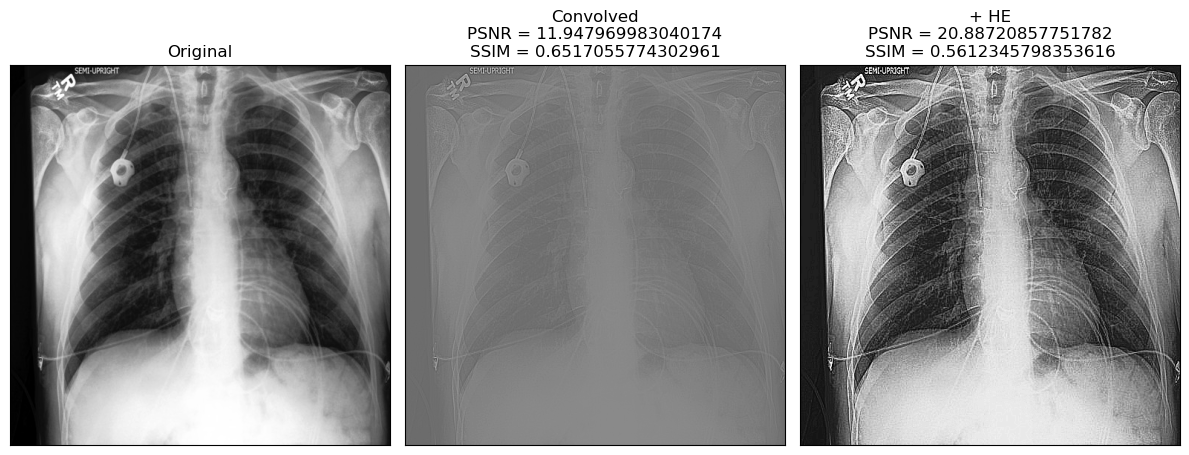

In [633]:
fig,ax = plt.subplots(1,3,figsize=(12,7))

ax[0].imshow(img_arr_he, cmap="gray")
ax[0].set(title="Original", xticks=[], yticks=[])

ax[1].imshow(conv, cmap="gray")
ax[1].set(title=f"Convolved\nPSNR = {conv_psnr}\nSSIM = {conv_ssim}", xticks=[], yticks=[])

ax[2].imshow(conv_he, cmap="gray")
ax[2].set(title=f"+ HE\nPSNR = {conv_he_psnr}\nSSIM = {conv_he_ssim}", xticks=[], yticks=[])

plt.tight_layout()
plt.show()

In [634]:
# def unsharp_masking(X, sigma, amount):
#     """ Use unsharp masking

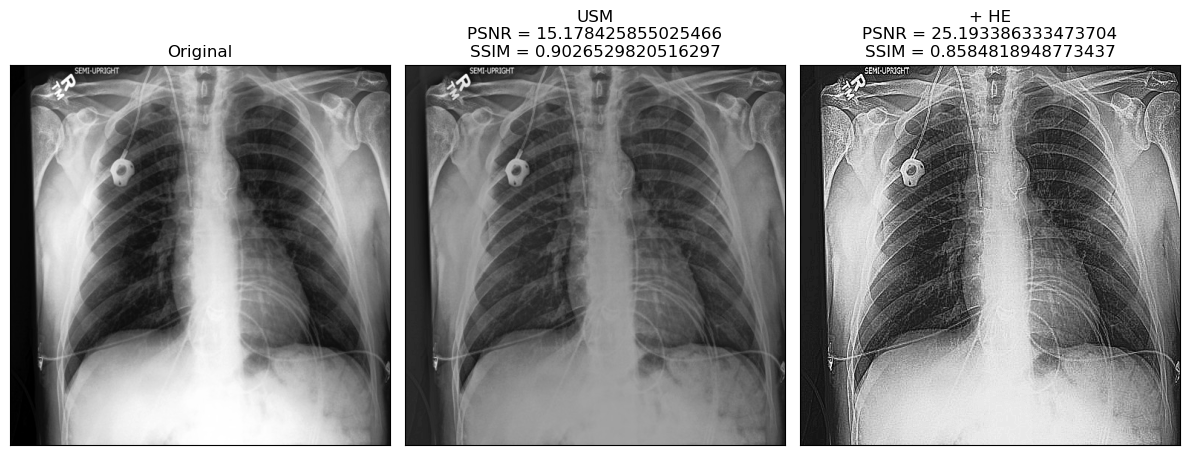

In [635]:
fig,ax = plt.subplots(1,3,figsize=(12,7))

ax[0].imshow(img_arr_he, cmap="gray")
ax[0].set(title="Original", xticks=[], yticks=[])

ax[1].imshow(usm, cmap="gray")
ax[1].set(title=f"USM\nPSNR = {usm_psnr}\nSSIM = {usm_ssim}", xticks=[], yticks=[])

ax[2].imshow(conv_he, cmap="gray")
ax[2].set(title=f"+ HE\nPSNR = {usm_he_psnr}\nSSIM = {usm_he_ssim}", xticks=[], yticks=[])

plt.tight_layout()
plt.show()

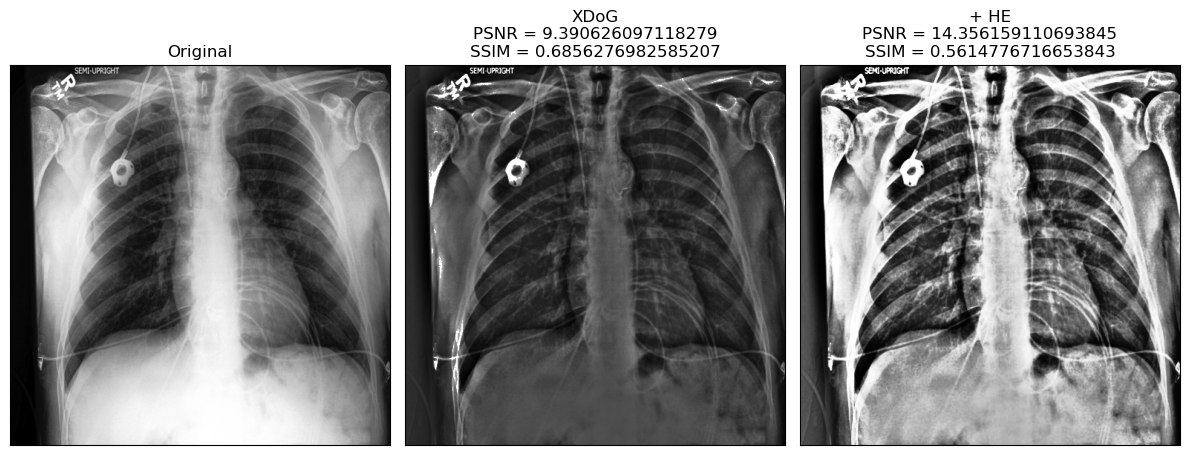

In [636]:
fig,ax = plt.subplots(1,3,figsize=(12,7))

ax[0].imshow(img_arr_he, cmap="gray")
ax[0].set(title="Original", xticks=[], yticks=[])

ax[1].imshow(xdog1, cmap="gray")
ax[1].set(title=f"XDoG\nPSNR = {xdog1_psnr}\nSSIM = {xdog1_ssim}", xticks=[], yticks=[])

ax[2].imshow(xdog1_he, cmap="gray")
ax[2].set(title=f"+ HE\nPSNR = {xdog1_he_psnr}\nSSIM = {xdog1_he_ssim}", xticks=[], yticks=[])

plt.tight_layout()
plt.show()

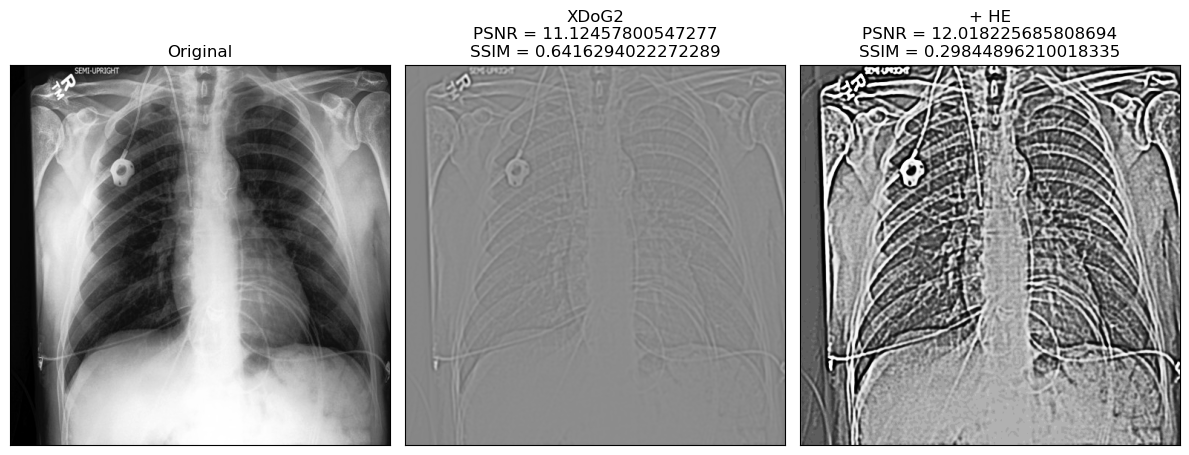

In [637]:
fig,ax = plt.subplots(1,3,figsize=(12,7))

ax[0].imshow(img_arr_he, cmap="gray")
ax[0].set(title="Original", xticks=[], yticks=[])

ax[1].imshow(xdog2, cmap="gray")
ax[1].set(title=f"XDoG2\nPSNR = {xdog2_psnr}\nSSIM = {xdog2_ssim}", xticks=[], yticks=[])

ax[2].imshow(xdog2_he, cmap="gray")
ax[2].set(title=f"+ HE\nPSNR = {xdog2_he_psnr}\nSSIM = {xdog2_he_ssim}", xticks=[], yticks=[])

plt.tight_layout()
plt.show()

In [ ]:
# Get the PSNR and SSIM between the base512 image and the convolution and unsharp masking pipelines

(1252, 2726)
(991, 2406)
(1872, 1934)
(1579, 2078)
(1646, 2320)
(0, 2827)


C:\Users\johnt\AppData\Local\Temp\ipykernel_43268\1978704143.py:33: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.imshow(img_arr, cmap="gray")


(1591, 2418)
(1934, 2268)
(2672, 3971)
(2033, 1932)
(2063, 2067)
(1418, 2004)
(1992, 2048)
(2070, 2156)
(1809, 2211)
(3293, 2888)
(2125, 2119)
(1874, 2602)
(1436, 1714)
(1773, 2122)
(1952, 2111)
(1618, 2275)
(2041, 2091)
(1699, 2268)
(667, 2827)
(2319, 2120)
(2319, 2096)
(2151, 1994)
(2132, 2177)
(1131, 2406)
(2007, 2142)
(2191, 1851)
(1728, 2024)
(2190, 2121)
(2230, 2302)
(1669, 2539)


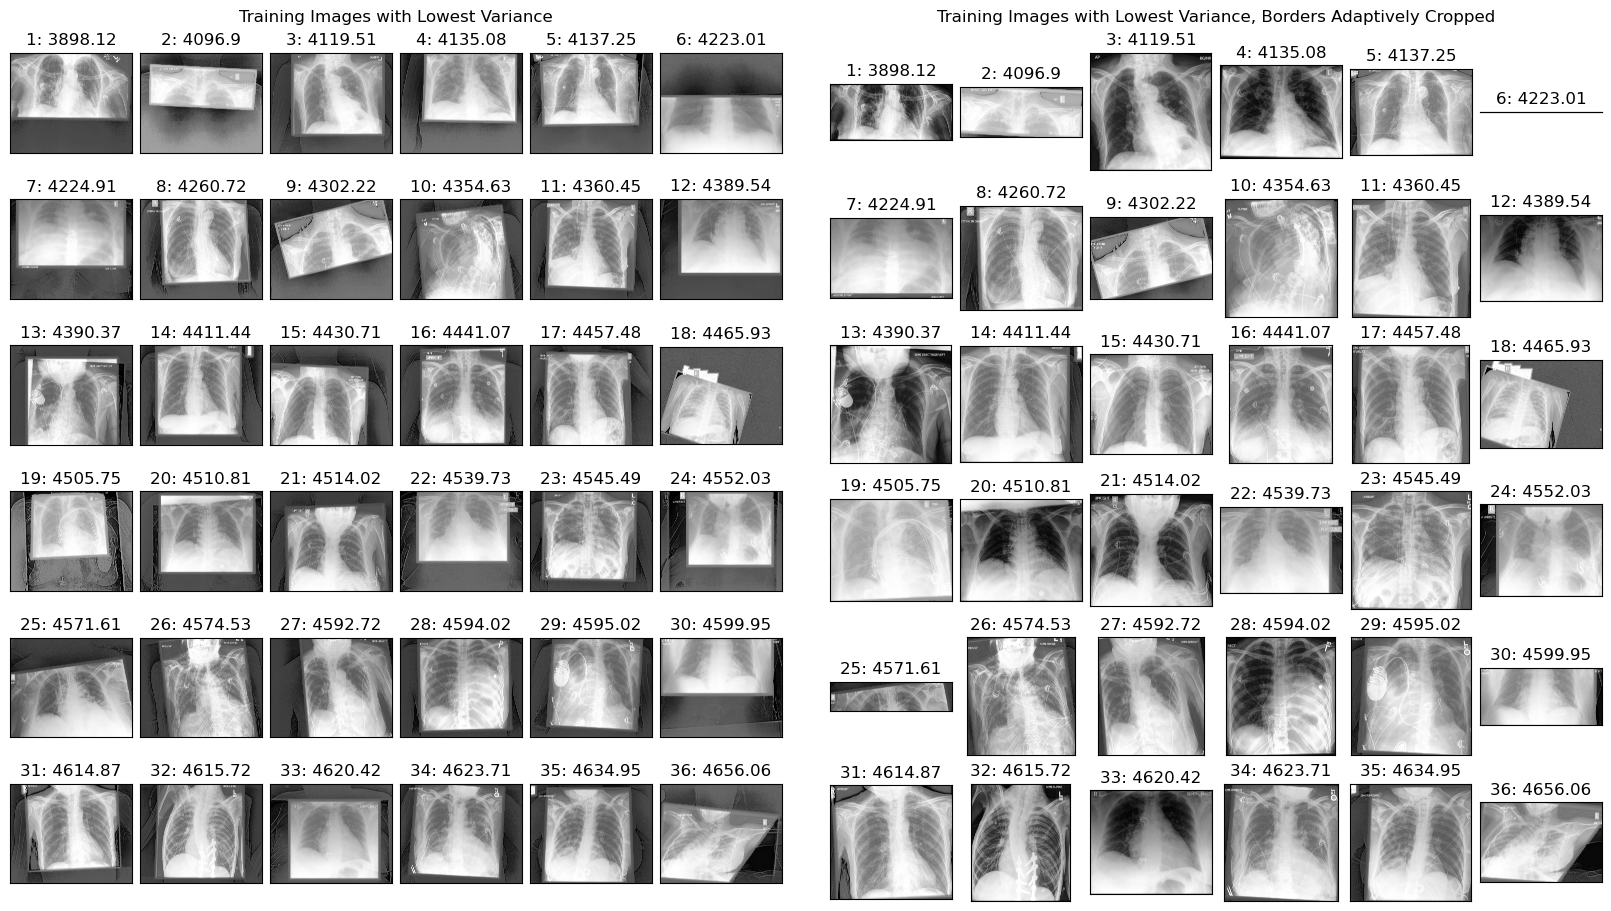

In [579]:
# Testing cropping borders
train_stats2 = train_stats[~train_stats["source_file_path"].isin(filter_out_paths)]
threshold_range = 0.8 * (scale_max - scale_min)
crop_q1_threshold = 0.1 * (scale_max - scale_min)
crop_q3_threshold = 0.9 * (scale_max - scale_min)

# Viewing the images with the lowest variances
var = "source_img_var"
df = train_stats2.sort_values(by=var, ascending=True)[source_cols]

# --- Prepare subfigures
fig = plt.figure(constrained_layout=True, figsize=(16,9))
subfigs = fig.subfigures(1,2, wspace=0.05)
subfigs[0].suptitle("Training Images with Lowest Variance")
subfigs[1].suptitle("Training Images with Lowest Variance, Borders Adaptively Cropped")

axes0 = subfigs[0].subplots(6,6)
axes1 = subfigs[1].subplots(6,6)

# --- Get data and display it
df0 = df.head(36)[source_cols]
for i,(ax,img_var,path) in enumerate(zip(axes0.flatten(), df0[var], df0["source_file_path"]), start=1):
    with Image.open(path) as img:
        ax.imshow(img, cmap="gray")
        ax.set(title=f"{i}: {round(img_var,2)}",xticks=[], yticks=[])
# df1 = df.tail(36)[source_cols][::-1]
for i,(ax,img_var,path) in enumerate(zip(axes1.flatten(), df0[var], df0["source_file_path"]), start=1):
    with Image.open(path) as img:
        img_arr = np.array(img)
        img_arr = scale_range(img_arr, scale_min, scale_max)
        img_arr = crop_borders(img_arr, threshold_range, crop_q1_threshold, crop_q3_threshold)
        print(img_arr.shape)
        ax.imshow(img_arr, cmap="gray")
        ax.set(title=f"{i}: {round(img_var,2)}",xticks=[], yticks=[])

# fig.savefig("images/img_viewVariances.jpg")

In [638]:
def pipeline1(img_arr, kernel, he_sigma, scale_min, scale_max):
    """Scale the range, sharpen by convolving with a kernel, then equalize the histogram"""
    output = scale_range(img_arr, scale_min, scale_max)
    output = convolve(output, kernel)
    output = histogram_equalization(output, scale_min, scale_max, he_sigma)
    return output

def pipeline2(img_arr, weight, usm_sigma, he_sigma, scale_min, scale_max):
    """Scale the range, sharpen via unsharp masking, then equalize the histogram"""
    output = scale_range(img_arr, scale_min, scale_max)
    output = unsharp_masking(output, usm_sigma, weight)
    output = histogram_equalization(output, scale_min, scale_max, he_sigma)
    return output

In [639]:
test1 = pipeline1(img_arr, sharpen_kernel, he_sigma, scale_min, scale_max)
test2 = pipeline2(img_arr, weight, usm_sigma, he_sigma, scale_min, scale_max)

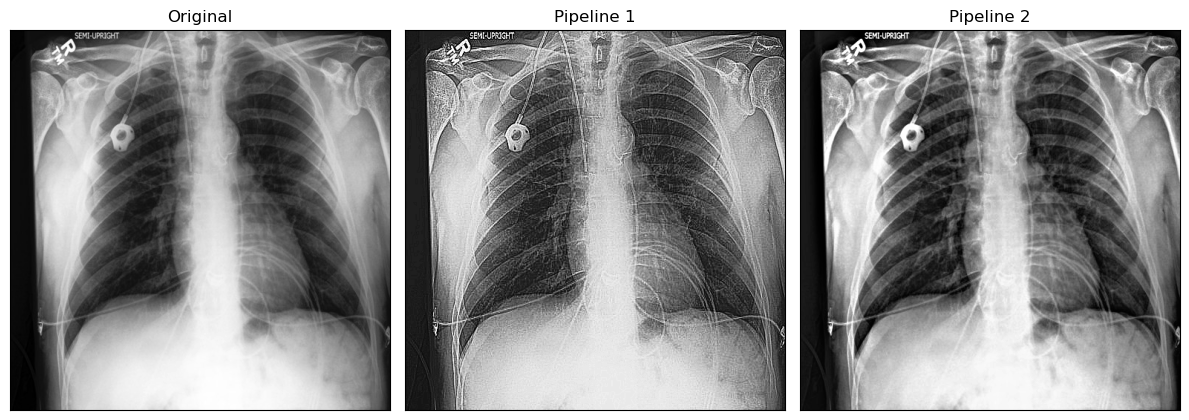

In [641]:
fig,ax = plt.subplots(1,3,figsize=(12,7))

ax[0].imshow(img_arr, cmap="gray")
ax[0].set(title="Original", xticks=[], yticks=[])

ax[1].imshow(test1, cmap="gray")
ax[1].set(title="Pipeline 1", xticks=[], yticks=[])

ax[2].imshow(test2, cmap="gray")
ax[2].set(title="Pipeline 2", xticks=[], yticks=[])

plt.tight_layout()
plt.show()